# 勾配降下法の最適化アルゴリズム比較

PRML Figure 6.10 で紹介されているガウス過程による回帰計算における、ハイパーパラメータの最適化を3種類のアルゴリズムで実施します。

* 俺々デルタ
* RMSprop
* Adadelta

これらは、勾配降下法における学習率をどのように変化させるかという点で、その振る舞いが異なります。

「俺々デルタ」は解の特性を理解した上で、この問題に特化して設定したアルゴリズムです。RMSpropとAdadeltaについては、[An overview of gradient descent optimization algorithms](http://sebastianruder.com/optimizing-gradient-descent/)を参考にしてください。

対象とする問題そのものの解説は詳しくはしていませんが、ざっくりとした解説は[PRML6.4.2 Gaussian processes for regressionのメモ](http://enakai00.hatenablog.com/entry/2016/03/17/103542)を参照してください。

## 事前準備

データセットを用意します。特徴変数 (x1, x2, x3) から t を推定します。x1 と t には真の相関があり、x2 と t には擬似的な弱い相関があります。x3 と t には相関はありません。 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import normal

In [2]:
def prep_data():
    x1 = normal(0.0, 0.5, num_data)
    x2 = x1 + normal(0.0, 0.01, num_data)
    x3 = normal(0.0, 0.5, num_data)
    t = np.sin(2.0*np.pi*x1) + normal(0, 1.0/np.sqrt(beta), num_data)
    return t, x1, x2, x3

In [3]:
np.random.seed(20160317)
num_data = 100
beta = 36.0
t0 = 1.0
t, x1, x2, x3 = prep_data()

ガウス過程による回帰で必要となる相関行列とそのハイパーパラメータによる偏微分を定義しておきます。

In [4]:
def matrix_c():
    c = np.zeros(num_data*num_data).reshape(num_data,num_data)
    for n in range(num_data):
        for m in range(num_data):
            c[n][m] = t0 * np.exp(-0.5 * (
                              eta[0]*(x1[n]-x1[m])*(x1[n]-x1[m]) +
                              eta[1]*(x2[n]-x2[m])*(x2[n]-x2[m]) +
                              eta[2]*(x3[n]-x3[m])*(x3[n]-x3[m]) ))
    for n in range(num_data):
        c[n][n] += 1.0/beta
    return c

In [5]:
def deru_c(x):
    c = matrix_c()
    for n in range(num_data):
        c[n][n] -= 1.0/beta
    for n in range(num_data):
        for m in range(num_data):
            c[n][m] *= -0.5 * (x[n]-x[m])*(x[n]-x[m])
    return c

## 俺々デルタ

3つのハイパーパラメータ eta1, eta2, eta3 は、初期値 1.0 から開始して、eta1, eta2 は値が大きくなり、eta3 は 0 に近づくことが期待されます。そこで、eta の絶対値に比例した学習率を設定します。

In [6]:
def run_ore_delta():
    global eta
    eta1s, eta2s, eta3s = [eta[0]], [eta[1]], [eta[2]]
    for i in range(1, iter_num+1):
        c = matrix_c()
        c_inv = np.linalg.inv(c)
        d = [deru_c(x1), deru_c(x2), deru_c(x3)]
        for j in range(3):
            tmp0 = np.dot(t, np.dot(c_inv, np.dot(d[j], np.dot(c_inv, t))))
            delta = -0.5 * np.trace(np.dot(c_inv, d[j])) + 0.5 * tmp0
            eta[j] += rate * np.abs(eta[j]) * delta

        if i % 50 == 0:
            c = matrix_c()
            c_inv = np.linalg.inv(c)
            logp = -0.5*np.log(np.linalg.det(c))-0.5*np.dot(t,np.dot(c_inv,t))-0.5*num_data*np.log(2*np.pi)
            eta1s.append(eta[0])
            eta2s.append(eta[1])
            eta3s.append(eta[2])
            print logp, eta
            
    return eta1s, eta2s, eta3s

In [7]:
iter_num = 1000
rate = 0.005
eta = [1.0, 1.0, 1.0]
etas = run_ore_delta()

12.0335824737 [4.342169427439778, 4.4043462474642165, 0.053396100953989861]
14.4512929325 [4.8096732146036274, 4.764030921202238, 2.3642924289125619e-10]
14.5229100863 [5.0779604407036212, 4.8827876685669391, 4.0764218944919972e-19]
14.5499505097 [5.26000129014996, 4.9179753467593281, 1.5444544866120909e-27]
14.5638070037 [5.3951132235813297, 4.9111449215675771, 7.4402090776662281e-36]
14.5729730109 [5.5022682848765703, 4.8818721866877501, 3.4729028070375387e-44]
14.5801725253 [5.5917833776813586, 4.840493007509, 1.3569866498484345e-52]
14.5863722351 [5.6696453924373893, 4.7927989188216351, 4.0937429608295884e-61]
14.5919444715 [5.7394659151354199, 4.7421402135112922, 9.1234981682441494e-70]
14.5970471275 [5.8034800249572953, 4.6904852594227116, 1.4684900533241568e-78]
14.6017570282 [5.8630980030638922, 4.638994893311323, 1.6905304773418714e-87]
14.6061189423 [5.9192255932823041, 4.5883488123959646, 1.3892754395005683e-96]
14.6101641713 [5.9724558437956965, 4.5389366682935508, 8.173410

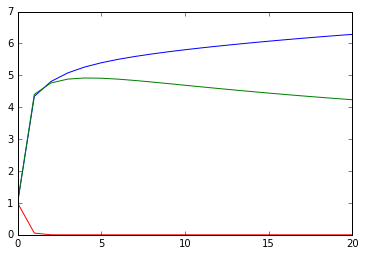

In [8]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
subplot.plot(np.arange(0,len(etas[0])), etas[0])
subplot.plot(np.arange(0,len(etas[1])), etas[1])
subplot.plot(np.arange(0,len(etas[2])), etas[2])

3つのハイパーパラメータそれぞれの予測値 t に対する相関の強さに応じて、ハイパーパラメータの値が綺麗に分離されています。

## RMSprop

RMSpropでは、「勾配の2乗の加重移動平均」の平方根に反比例する形で学習率を落とします。加重移動平均を用いることで、過去の移動の傾向をしばらく保持する効果があります。

In [9]:
  def run_rmsprop():
    global eta
    eta1s, eta2s, eta3s = [eta[0]], [eta[1]], [eta[2]]
    g = [0, 0, 0]

    for i in range(1, iter_num+1):
        c = matrix_c()
        c_inv = np.linalg.inv(c)
        d = [deru_c(x1), deru_c(x2), deru_c(x3)]
        for j in range(3):
            tmp0 = np.dot(t, np.dot(c_inv, np.dot(d[j], np.dot(c_inv, t))))
            delta = -0.5 * np.trace(np.dot(c_inv, d[j])) + 0.5 * tmp0
            g[j] = 0.9 * g[j] + 0.1 * delta*delta
            eta[j] += rate/np.sqrt((g[j]+0.00000001)) * delta        

        if i % 50 == 0:
            c = matrix_c()
            c_inv = np.linalg.inv(c)
            logp = -0.5*np.log(np.linalg.det(c))-0.5*np.dot(t,np.dot(c_inv,t))-0.5*num_data*np.log(2*np.pi)
            eta1s.append(eta[0])
            eta2s.append(eta[1])
            eta3s.append(eta[2])
            print logp, eta
            
    return eta1s, eta2s, eta3s

In [10]:
iter_num = 1000
rate = 0.01
eta = [1.0, 1.0, 1.0]
etas = run_rmsprop()

-106.894426936 [1.5254511370397215, 1.5256025920366749, 0.38409424518069207]
-35.5912451731 [1.94108957435976, 1.9413804410369635, 0.0078536918810286453]
-8.54751004062 [2.3543343756516526, 2.3543581462678818, 0.018507854532863698]
3.08250353948 [2.7704125945741902, 2.7707288429691554, 0.023487559859051928]
8.61243511998 [3.1917370187648904, 3.1910041231734114, 0.018637100527463334]
11.5391977969 [3.6197188672886154, 3.6177380885532049, 0.011609061612054069]
12.2563901421 [4.0366002829402303, 4.0068606277003003, 0.022290950159118705]
12.8099533448 [4.4668474823810183, 4.431205419370662, 0.025710823261111893]
12.9829239388 [4.7707464608376702, 4.7226604954089835, 0.028193429818454047]
13.0963196237 [4.8766245984034997, 4.8326786858795261, 0.026593898305123872]
14.6288454968 [5.2182239351375355, 5.1009994236759137, -0.0028119297497352712]
13.2834630802 [5.4679306798622438, 5.2051949924243539, 0.025022966924860005]
13.2598863111 [5.6377637190840533, 5.1356979608774544, 0.02581885087748150

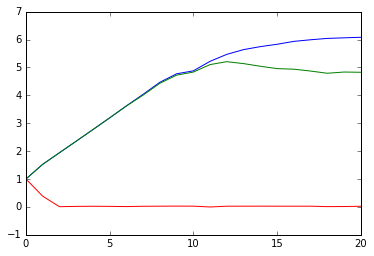

In [11]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
subplot.plot(np.arange(0,len(etas[0])), etas[0])
subplot.plot(np.arange(0,len(etas[1])), etas[1])
subplot.plot(np.arange(0,len(etas[2])), etas[2])

俺々デルタに比べて初期の変化が遅いようですが、後半はほぼ同じ結果に収束しています。

## Adadelta

Adadeltaは、「勾配の2乗の加重移動平均」の平方根に反比例すると同時に、「パラメータの変化量の2乗の加重移動平均」の平方根に比例する形で学習率を変化させます。過去の変化の傾向をより強く反映します。

In [12]:
 def run_adadelta():
    global eta
    eta1s, eta2s, eta3s = [eta[0]], [eta[1]], [eta[2]]
    g = [0, 0, 0]
    s = [0.1, 0.1, 0.1]

    for i in range(1, iter_num+1):
        c = matrix_c()
        c_inv = np.linalg.inv(c)
        d = [deru_c(x1), deru_c(x2), deru_c(x3)]
        for j in range(3):
            tmp0 = np.dot(t, np.dot(c_inv, np.dot(d[j], np.dot(c_inv, t))))
            delta = -0.5 * np.trace(np.dot(c_inv, d[j])) + 0.5 * tmp0
            g[j] = 0.9 * g[j] + 0.1 * delta*delta
            v = np.sqrt((s[j]+0.00000001)/(g[j]+0.00000001)) * delta        
            s[j] = 0.9 * s[j] + 0.1 * v*v
            eta[j] += v

        if i % 50 == 0:
            c = matrix_c()
            c_inv = np.linalg.inv(c)
            logp = -0.5*np.log(np.linalg.det(c))-0.5*np.dot(t,np.dot(c_inv,t))-0.5*num_data*np.log(2*np.pi)
            eta1s.append(eta[0])
            eta2s.append(eta[1])
            eta3s.append(eta[2])
            print logp, eta
            
    return eta1s, eta2s, eta3s

In [13]:
iter_num = 1000
rate = 0.005
eta = [1.0, 1.0, 1.0]
etas = run_adadelta()

0.0700781925678 [3.5517885815674424, 3.5622517650790204, 1.0252133365462741]
4.0936227496 [3.9310499847906417, 3.951268544299491, 0.68468485386027089]
9.63035997148 [4.1491142258000684, 4.1810100842127174, 0.22493415022138086]
13.0041113081 [4.3149821268153152, 4.3530682381576318, 0.017249899663531368]
14.3639224698 [4.4521458811891952, 4.4607220896116155, -0.0028184099101959213]
14.4580489989 [4.5672006608038727, 4.5320754138998547, -0.002337277191249557]
14.5115169328 [4.6670545891173063, 4.5850019326850697, -0.0026034928673056078]
14.5490136624 [4.7557079608768564, 4.6263460796629845, -0.0026100107726852641]
14.5752334338 [4.8355017732803027, 4.6586659309618819, -0.0026822609196430524]
14.59972579 [4.9081623287114864, 4.6837430954046342, -0.0026202673983063913]
14.6152324866 [4.9749539734300381, 4.7025349646839265, -0.0026950562328068787]
14.6320353645 [5.0369280479874243, 4.7156220964750171, -0.0026293329840486922]
14.6418417016 [5.0949156607757056, 4.7224580238828171, -0.002710728

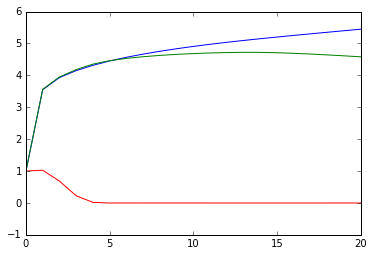

In [14]:
fig = plt.figure()
subplot = fig.add_subplot(1,1,1)
subplot.plot(np.arange(0,len(etas[0])), etas[0])
subplot.plot(np.arange(0,len(etas[1])), etas[1])
subplot.plot(np.arange(0,len(etas[2])), etas[2])

初期の変化は、RMSpropよりも早くなっています。後半の動きは、俺々デルタよりはやや遅いようです。

## 結論

当たり前ですが、問題の特性を理解した上で、アルゴリズムを決定するのがベストです。現実の問題では、最初から特性がわかるものではないですので、まずは、汎用性のあるアルゴリズムで当たりをつけて特性をさぐりながら、最適なアルゴリズムを探していきましょう。